# Voice Intercom – Milestone 1 Notebook
Data reading, EDA, spectrogram creation, and a simple CNN that trains until interrupted.

In [14]:
import os, random, time, json, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display, soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

## Configuration Parameters

In [15]:
class Args: pass
args = Args()

args.data = "./dataset"
args.sr = 16000
args.n_mels = 64
args.fixed_length = 200

args.batch_size = 32
args.lr = 1e-3
args.weight_decay = 1e-4

args.test_size = 0.15
args.val_size = 0.15

args.seed = int(time.time()) % 100000

## Utilities and Audio Functions

In [16]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def ensure_dir(path):
    Path(path).mkdir(parents=True, exist_ok=True)


set_seed(args.seed)

ensure_dir("./models")
ensure_dir("./outputs")

In [17]:
def build_filelist(root):
    pairs = []
    label_map = {"not_allowed": 0, "allowed": 1}

    for class_name, label in label_map.items():
        class_dir = Path(root) / class_name
        for f in class_dir.rglob("*.wav"):
            pairs.append((str(f), label))

    return pairs


pairs = build_filelist(args.data)
print("Total files:", len(pairs))

Total files: 41490


## Exploratory Data Analysis

In [18]:
allowed = [p for p in pairs if p[1] == 1]
not_allowed = [p for p in pairs if p[1] == 0]

min_len = min(len(allowed), len(not_allowed))
allowed = random.sample(allowed, min_len)
not_allowed = random.sample(not_allowed, min_len)

pairs = allowed + not_allowed
random.shuffle(pairs)

print("Balanced dataset size:", len(pairs))

Balanced dataset size: 41142


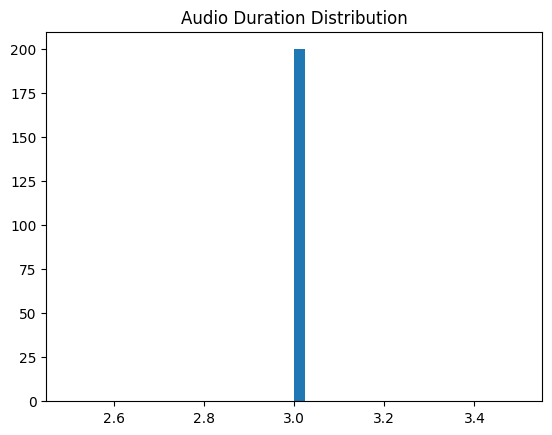

In [19]:
durations = [librosa.get_duration(path=p) for p, _ in pairs[:200]]
plt.hist(durations, bins=40)
plt.title("Audio Duration Distribution")
plt.show()

## Spectrogram Helpers

In [20]:
def load_audio(path, sr):
    y, _ = librosa.load(path, sr=sr)
    return y

def make_mel(y, sr):
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=args.n_mels
    )
    return librosa.power_to_db(S, ref=np.max)

In [21]:
def add_noise(y, snr_db=10):
    signal_power = np.mean(y**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), size=y.shape)
    return y + noise

## Dataset and DataLoader

In [22]:
class SpectrogramDataset(Dataset):
    def __init__(self, pairs, fixed_length=200, augment=False):
        self.pairs = pairs
        self.fixed_length = fixed_length
        self.augment = augment

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path, label = self.pairs[idx]
        y = load_audio(path, args.sr)

        if self.augment:
            y = self.add_noise(y)
            y = self.pitch_shift(y)
            y = self.time_stretch(y)

        S = make_mel(y, args.sr)
        S = (S - S.mean()) / (S.std() + 1e-9)

        if S.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - S.shape[1]
            S = np.pad(S, ((0,0),(0,pad_width)), mode='constant')
        else:
            S = S[:, :self.fixed_length]

        return torch.tensor(S).unsqueeze(0).float(), torch.tensor(label).long()

    def add_noise(self, y, snr_db=10):
        rms_signal = np.sqrt(np.mean(y**2))
        rms_noise = rms_signal / (10**(snr_db/20))
        noise = np.random.normal(0, rms_noise, y.shape[0])
        return y + noise

    def pitch_shift(self, y, n_steps=1):
        return librosa.effects.pitch_shift(y, sr=args.sr, n_steps=random.uniform(-n_steps, n_steps))

    def time_stretch(self, y, rate_range=(0.9, 1.1)):
        rate = random.uniform(*rate_range)
        try:
            return librosa.effects.time_stretch(y, rate)
        except:
            return y

## Train / Val / Test Split

In [23]:
paths = [p for p, _ in pairs]
labels = [l for _, l in pairs]

tr_p, te_p, tr_l, te_l = train_test_split(
    paths, labels,
    test_size=args.test_size,
    stratify=labels,
    random_state=args.seed
)

tr_p, va_p, tr_l, va_l = train_test_split(
    tr_p, tr_l,
    test_size=args.val_size,
    stratify=tr_l,
    random_state=args.seed
)

train_pairs = list(zip(tr_p, tr_l))
val_pairs   = list(zip(va_p, va_l))
test_pairs  = list(zip(te_p, te_l))

train_loader = DataLoader(
    SpectrogramDataset(train_pairs, augment=True),
    batch_size=args.batch_size, shuffle=True
)
val_loader = DataLoader(
    SpectrogramDataset(val_pairs, augment=False),
    batch_size=args.batch_size
)
test_loader = DataLoader(
    SpectrogramDataset(test_pairs, augment=False),
    batch_size=args.batch_size
)

print("Train / Val / Test loaders created:")
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")



Train / Val / Test loaders created:
Train: 29724, Val: 5246, Test: 6172


## Advanced Model

In [24]:
class SimpleConvNet(nn.Module):
    def __init__(self, fixed_length=200):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, padding=1)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, args.n_mels, fixed_length)
            x = self.pool(F.relu(self.c1(dummy)))
            x = self.pool(F.relu(self.c2(x)))
            self.flattened = x.numel()

        self.fc = nn.Linear(self.flattened, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.c1(x)))
        x = self.pool(F.relu(self.c2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [25]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X, y in loader:
            out = model(X)
            preds.extend(out.argmax(1).tolist())
            labels.extend(y.tolist())

    return f1_score(labels, preds, average="macro")


## Infinite Training Loop (Interrupt Kernel to Stop)

In [28]:
ensure_dir("./models")
ensure_dir("./outputs")

model = SimpleConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

loss_history = []
train_f1_history = []
val_f1_history = []
real_test_f1_history = []

epoch = 1
plt.ioff()

while True:
    try:
        model.train()
        losses = []
        train_preds = []
        train_labels = []

        for X, y in train_loader:
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            train_preds.extend(out.argmax(1).tolist())
            train_labels.extend(y.tolist())

        avg_loss = np.mean(losses)
        train_f1 = f1_score(train_labels, train_preds, average="macro")

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                out = model(X)
                val_preds.extend(out.argmax(1).tolist())
                val_labels.extend(y.tolist())
        val_f1 = f1_score(val_labels, val_preds, average="macro")

        real_preds, real_labels = [], []
        with torch.no_grad():
            for X, y in test_loader:
                out = model(X)
                real_preds.extend(out.argmax(1).tolist())
                real_labels.extend(y.tolist())
        real_test_f1 = f1_score(real_labels, real_preds, average="macro")

        loss_history.append(avg_loss)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)
        real_test_f1_history.append(real_test_f1)

        print(f"Epoch {epoch} | Loss {avg_loss:.4f} | Train F1 {train_f1:.3f} | "
              f"Val F1 {val_f1:.3f} | Real Test F1 {real_test_f1:.3f}")

        torch.save(model.state_dict(), f"./models/model_epoch_{epoch}.pth")

        fig, ax1 = plt.subplots()
        ax1.set_title("Training Curves")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.plot(loss_history, label="Loss", color='blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel("F1 Score")
        ax2.plot(train_f1_history, label="Train F1", color='green', linestyle='-')
        ax2.plot(val_f1_history, label="Val F1", color='orange', linestyle='--')
        ax2.plot(real_test_f1_history, label="Real Test F1", color='red', linestyle=':')

        fig.legend(loc="upper left")
        fig.tight_layout()
        fig.savefig(f"./outputs/epoch_{epoch:03d}.png")
        plt.close(fig)

        epoch += 1

    except KeyboardInterrupt:
        print("Training interrupted by user.")
        break


Epoch 1 | Loss 0.4252 | Train F1 0.809 | Val F1 0.830 | Real Test F1 0.833
Epoch 2 | Loss 0.3467 | Train F1 0.847 | Val F1 0.775 | Real Test F1 0.764
Epoch 3 | Loss 0.3212 | Train F1 0.859 | Val F1 0.854 | Real Test F1 0.854
Epoch 4 | Loss 0.3046 | Train F1 0.869 | Val F1 0.843 | Real Test F1 0.842
Epoch 5 | Loss 0.2944 | Train F1 0.875 | Val F1 0.856 | Real Test F1 0.860
Epoch 6 | Loss 0.2870 | Train F1 0.878 | Val F1 0.833 | Real Test F1 0.839
Epoch 7 | Loss 0.2790 | Train F1 0.880 | Val F1 0.855 | Real Test F1 0.861
Epoch 8 | Loss 0.2719 | Train F1 0.884 | Val F1 0.823 | Real Test F1 0.815
Epoch 9 | Loss 0.2653 | Train F1 0.885 | Val F1 0.864 | Real Test F1 0.872
Epoch 10 | Loss 0.2585 | Train F1 0.892 | Val F1 0.869 | Real Test F1 0.871
Epoch 11 | Loss 0.2598 | Train F1 0.889 | Val F1 0.873 | Real Test F1 0.877
Epoch 12 | Loss 0.2504 | Train F1 0.894 | Val F1 0.868 | Real Test F1 0.873
Epoch 13 | Loss 0.2538 | Train F1 0.894 | Val F1 0.867 | Real Test F1 0.870
Epoch 14 | Loss 0.248

In [27]:
model = SimpleConvNet()
model.load_state_dict(torch.load("./models/model_epoch_XX.pth"))
model.eval()


def preprocess_audio(path):
    y, _ = librosa.load(path, sr=args.sr)
    S = make_mel(y)
    S = (S - S.mean()) / (S.std() + 1e-9)

    if S.shape[1] < args.fixed_length:
        S = np.pad(S, ((0, 0), (0, args.fixed_length - S.shape[1])))
    else:
        S = S[:, :args.fixed_length]

    return torch.tensor(S).unsqueeze(0).unsqueeze(0).float()


X = preprocess_audio("my_voice.wav")
with torch.no_grad():
    pred = model(X).argmax(1).item()

print("ALLOWED" if pred == 1 else "NOT ALLOWED")

FileNotFoundError: [Errno 2] No such file or directory: './models/model_epoch_XX.pth'